# Определение стоимости автомобилей

Наш сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. Оно имеет удобный инструмент, чтобы оценить стоимость уже имеющихся у нас авто. Нами уже скомпонованы исторические данные: характеристик, комплектация, цены.

нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План работы

- Выполнить загрузку и подготовку данных
- Произвести обучение моделей. Используем алгоритмы: LinearRegression, CatBoostRegressor, DecisionTreeRegressor, LGBMRegressor
- Выполним анализ скорости работы и качества моделей




## Подготовка данных

In [104]:
# Подгружаем модули
import pandas as pd
import numpy as np
import os
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score

In [105]:

pd.options.mode.chained_assignment = None

In [106]:
# Загрузка данных
data = pd.read_csv('/datasets/autos.csv')

In [107]:
# Ознакомимся
data


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [108]:
# Инфромация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [109]:
#дубликаты
data.duplicated().sum()

4

In [110]:
# Удалим найденные 
data = data.drop_duplicates()

# **Признаки**
*	DateCrawled — дата скачивания анкеты из базы
*	VehicleType — тип автомобильного кузова
*	RegistrationYear — год регистрации автомобиля
*	Gearbox — тип коробки передач
*	Power — мощность (л. с.)
*	Model — модель автомобиля
*	Kilometer — пробег (км)
*	RegistrationMonth — месяц регистрации автомобиля
*	FuelType — тип топлива
*	Brand — марка автомобиля
*	NotRepaired — была машина в ремонте или нет
*	DateCreated — дата создания анкеты
*	NumberOfPictures — количество фотографий автомобиля
*	PostalCode — почтовый индекс владельца анкеты (пользователя)
*	LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)


Предполагаю, что для обучения модели не нужны будут признаки с датой, индексом и количеством фотографий в объявлении, поэтому сформируем датасет для модели без этих признаков. Оставим год регистрации

In [111]:
# оставим признаки для обучения модели
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [112]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   NotRepaired       283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [113]:
# Проверим пропуски
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

Пропуски имеем в признаках:
* **VehicleType** - тип автомобильного кузова - заменим пропуски на unknown
* **Gearbox** — тип коробки передач, заменим пропуски на unknown (потому как могут быть еще варианты вариатор и робот)
* **Model** — модель автомобиля, заменим пропуски на unknown
* **FuelType** - тип топлива, поставим самый популярный бензин
* **NotRepaired** - была машина в ремонте или нет, если не указано, поставим не было ремонта


In [114]:
# посмотрим максимум, минимум и квантили:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Есть некорректные данные:
* Нулевая стоимость
* год выпуска минимум 1000 и максимум 9999
* указана мощность минимум 0 и максимум 20000

Проанализируем их количество и после примем решение, что с ними делать

Text(0.5, 1.0, '[count    354365.000000\nmean       2004.234481\nstd          90.228466\nmin        1000.000000\n25%        1999.000000\n50%        2003.000000\n75%        2008.000000\nmax        9999.000000\nName: RegistrationYear, dtype: float64]')

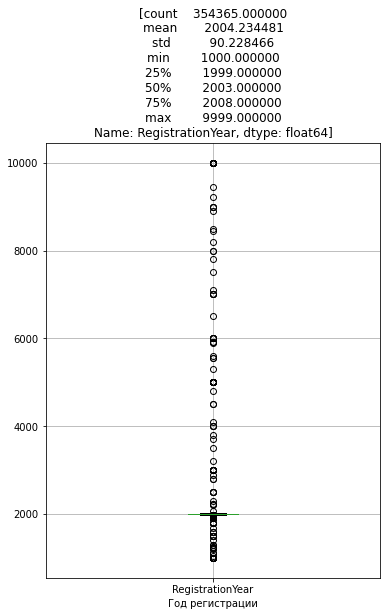

In [115]:
data.boxplot(['RegistrationYear'], figsize=(6,8))
plt.xlabel('Год регистрации')
plt.title([data['RegistrationYear'].describe()])

Text(0.5, 1.0, "['Количество', 354194]")

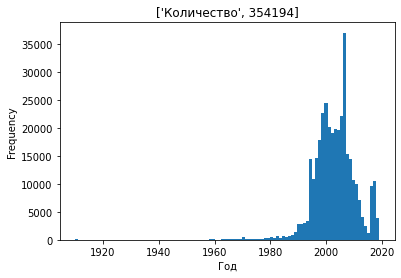

In [116]:
#
data.query('1900 <= RegistrationYear <= 2022')['RegistrationYear'].plot(kind='hist', bins=100)
plt.xlabel('Год')
plt.title(['Количество', data.query('1900 <= RegistrationYear <= 2022')['RegistrationYear'].count()])

Сплошные выбросы, выберем диапазон с 1985 по 2022 год для обучения модели

In [117]:
# Исправление, выберем диапазон с 2016 года
#data = data.query('1985 <= RegistrationYear <= 2022')
data = data.query('2016 <= RegistrationYear <= 2022')

In [118]:
# Исправление, выберем диапазон с 2016 года
#data = data.query('1985 <= RegistrationYear <= 2022')
data = data.query('1985 <= RegistrationYear <= 2016')

Text(0.5, 1.0, '[count     9599.000000\nmean      2104.498073\nstd       3024.341955\nmin          0.000000\n25%        400.000000\n50%        950.000000\n75%       2499.000000\nmax      20000.000000\nName: Price, dtype: float64]')

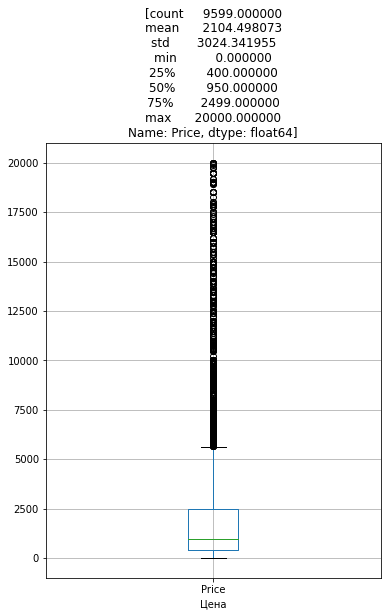

In [119]:
data.boxplot(['Price'], figsize=(6,8))
plt.xlabel('Цена')
plt.title([data['Price'].describe()])

Text(0.5, 1.0, "['Количество', 752]")

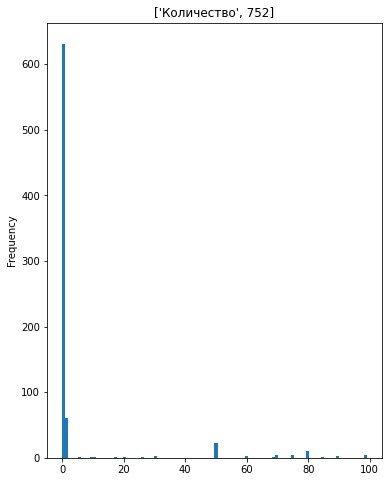

In [120]:
#Уберем объявления дешевле 100
data.query('Price < 100')['Price'].plot(kind='hist', bins=100, figsize=(6,8))
plt.title(['Количество', data.query('Price < 100')['Price'].count()])

In [121]:
#Для обучения модели оставим объявления от 100
data = data.query('Price >= 100')
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
35,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
52,1400,NaN,2016,manual,55,other,5000,NaN,hyundai,NaN
...,...,...,...,...,...,...,...,...,...,...
354107,395,NaN,2016,manual,60,golf,150000,petrol,volkswagen,NaN
354115,299,NaN,2016,manual,60,astra,150000,petrol,opel,yes
354169,3000,NaN,2016,manual,0,colt,150000,gasoline,mitsubishi,no
354198,1350,NaN,2016,manual,0,clk,150000,NaN,mercedes_benz,yes


**Мощность**

Text(0.5, 1.0, '[count     8847.000000\nmean        79.858709\nstd        269.683773\nmin          0.000000\n25%          0.000000\n50%         75.000000\n75%        107.000000\nmax      13616.000000\nName: Power, dtype: float64]')

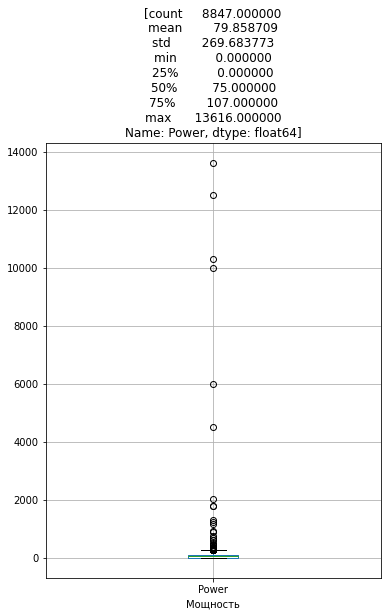

In [122]:
data.boxplot(['Power'], figsize=(6,8))
plt.xlabel('Мощность')
plt.title([data['Power'].describe()])

Text(0.5, 1.0, "['Количество', 2893]")

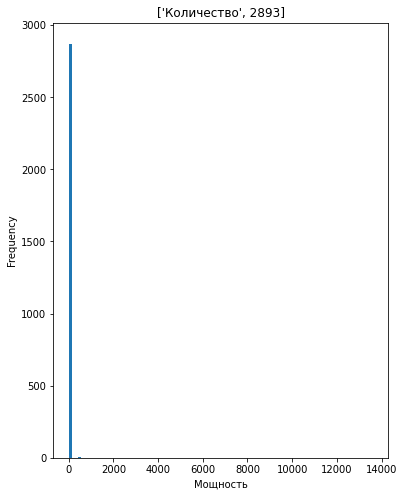

In [123]:
# Посмотрим объявления с нереальной мощностью
#Было
#data.query('((Power <= 50) or (Power >= 1300))')['Power'].plot(kind='hist', bins=100, figsize=(6,8))
#Стало
data.query('((Power <= 50) or (Power >= 450))')['Power'].plot(kind='hist', bins=100, figsize=(6,8))
plt.xlabel('Мощность')
plt.title(['Количество', data.query('((Power <= 50) or (Power >= 450))')['Price'].count()])

In [124]:
# Их существенное количество, чтобы просто удалить, заменим такие значения на медианные по модели. 
#Было
#data.loc[(data['Power'] <= 50) | (data['Power'] >= 1300), 'Power'] = None
#Стало
data.loc[(data['Power'] <= 50) | (data['Power'] >= 450), 'Power'] = None
data['Power'].isna().sum()

2893

In [125]:
#Методом transform пропуски в столбце Power заменим медианой по модели
#Было
#data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
#Стало
data['Power'] = data['Power'].fillna(data.groupby(['Model','Brand'])['Power'].transform('median'))

In [126]:
# осталось 5 тыс пропусков удалим их
data['Power'].isna().sum()

467

In [127]:
# осталось 5 тыс пропусков удалим их
data = data.loc[~data['Power'].isna()]

In [128]:
#Для обучения модели оставим объявления от 1000 
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,8380.000000,8380.0,8380.000000,8380.000000
mean,2308.437709,2016.0,99.740334,134697.494033
std,3090.991489,0.0,40.468207,35200.664512
min,100.000000,2016.0,51.000000,5000.000000
25%,500.000000,2016.0,75.000000,150000.000000
50%,1100.000000,2016.0,90.000000,150000.000000
75%,2700.000000,2016.0,116.000000,150000.000000
max,20000.000000,2016.0,387.000000,150000.000000


In [129]:
data[data['Power'] <= 1200 ]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
16,300,NaN,2016,NaN,60.0,polo,150000,petrol,volkswagen,NaN
31,899,NaN,2016,manual,60.0,clio,150000,petrol,renault,NaN
35,350,NaN,2016,manual,75.0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,75.0,kangoo,150000,gasoline,renault,no
52,1400,NaN,2016,manual,55.0,other,5000,NaN,hyundai,NaN
...,...,...,...,...,...,...,...,...,...,...
354107,395,NaN,2016,manual,60.0,golf,150000,petrol,volkswagen,NaN
354115,299,NaN,2016,manual,60.0,astra,150000,petrol,opel,yes
354169,3000,NaN,2016,manual,75.0,colt,150000,gasoline,mitsubishi,no
354198,1350,NaN,2016,manual,136.0,clk,150000,NaN,mercedes_benz,yes


In [130]:
# Проверим пропуски
data.isna().sum()

Price                  0
VehicleType         8228
RegistrationYear       0
Gearbox             1065
Power                  0
Model                743
Kilometer              0
FuelType            3192
Brand                  0
NotRepaired         3771
dtype: int64

Пропуски в наличии 

Пропуски в **FuelType** заменим на **petrol** (бензин)

Пропуски в **NotRepaired** заменим на No

Заменим на "заглушку" **unknown** пропуски в 
* VehicleType         
* Gearbox 
* Model                

In [131]:
# Что в ремонтах, уникальные значения
data['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [132]:
# Посмотрим какие типы топлива в датасете.
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'cng', 'hybrid', 'electric',
       'other'], dtype=object)

In [133]:
# Количество пропусков данных о ремонтах
data['NotRepaired'].isna().sum()

3771

In [134]:
# Заменим пропуски в данных о ремонте при пробеге более 100 тыс км на no - то есть машина ремонтировалась
data.loc[(data['Kilometer'] >= 100000)& (data['NotRepaired'].isna()), 'NotRepaired'] = 'no'
data['NotRepaired'].isna().sum()

373

In [135]:
# # Заменим пропуски в данных о ремонте при пробеге более 100 тыс км на yes - то есть машина не ремонтировалась
data.loc[(data['Kilometer'] < 100000)& (data['NotRepaired'].isna()),'NotRepaired'] = 'yes'
data['NotRepaired'].isna().sum()

0

In [136]:
# Пропуски в FuelType заменим на petrol (бензин)
data['FuelType'] = data['FuelType'].fillna('petrol')

пока заменим все пропуски на заглушку "unknown"

In [137]:
# Остальные пропуски заменим заглушкой 
data = data.fillna('unknown')

In [138]:
# пропуски ушли
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [139]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,8380.000000,8380.0,8380.000000,8380.000000
mean,2308.437709,2016.0,99.740334,134697.494033
std,3090.991489,0.0,40.468207,35200.664512
min,100.000000,2016.0,51.000000,5000.000000
25%,500.000000,2016.0,75.000000,150000.000000
50%,1100.000000,2016.0,90.000000,150000.000000
75%,2700.000000,2016.0,116.000000,150000.000000
max,20000.000000,2016.0,387.000000,150000.000000


<AxesSubplot:>

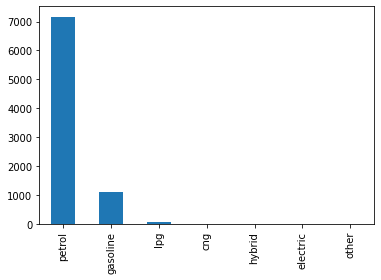

In [140]:
#Посмотрим как колчиество авто от типа топлива

data['FuelType'].value_counts().plot(kind='bar')

Ожидаемо больше всего бензиновых авто в объявлениях

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8380 entries, 16 to 354361
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             8380 non-null   int64  
 1   VehicleType       8380 non-null   object 
 2   RegistrationYear  8380 non-null   int64  
 3   Gearbox           8380 non-null   object 
 4   Power             8380 non-null   float64
 5   Model             8380 non-null   object 
 6   Kilometer         8380 non-null   int64  
 7   FuelType          8380 non-null   object 
 8   Brand             8380 non-null   object 
 9   NotRepaired       8380 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 720.2+ KB


Text(0.5, 1.0, "['Количество', 8380]")

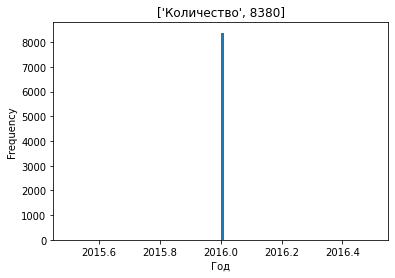

In [142]:
#
data.query('1900 <= RegistrationYear <= 2022')['RegistrationYear'].plot(kind='hist', bins=100)
plt.xlabel('Год')
plt.title(['Количество', data.query('1900 <= RegistrationYear <= 2022')['RegistrationYear'].count()])

In [143]:
# Посмотрим корреляцию
data.corr()


,Price,RegistrationYear,Power,Kilometer
Price,1.000000,NaN,0.424674,-0.372572
RegistrationYear,NaN,NaN,NaN,NaN
Power,0.424674,NaN,1.000000,0.039372
Kilometer,-0.372572,NaN,0.039372,1.000000



Наблюдаем умеренную корреляцию между ценой и годом авто, а также между ценой и мощностью авто. 

Есть обратная умеренная корреляция между ценой и пробегом.

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:89: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:90: UserWarning: Attempting to set identical bottom == top == 2016.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


array([[<AxesSubplot:xlabel='Price', ylabel='Price'>,
        <AxesSubplot:xlabel='RegistrationYear', ylabel='Price'>,
        <AxesSubplot:xlabel='Power', ylabel='Price'>,
        <AxesSubplot:xlabel='Kilometer', ylabel='Price'>],
       [<AxesSubplot:xlabel='Price', ylabel='RegistrationYear'>,
        <AxesSubplot:xlabel='RegistrationYear', ylabel='RegistrationYear'>,
        <AxesSubplot:xlabel='Power', ylabel='RegistrationYear'>,
        <AxesSubplot:xlabel='Kilometer', ylabel='RegistrationYear'>],
       [<AxesSubplot:xlabel='Price', ylabel='Power'>,
        <AxesSubplot:xlabel='RegistrationYear', ylabel='Power'>,
        <AxesSubplot:xlabel='Power', ylabel='Power'>,
        <AxesSubplot:xlabel='Kilometer', ylabel='Power'>],
       [<AxesSubplot:xlabel='Price', ylabel='Kilometer'>,
        <AxesSubplot:xlabel='RegistrationYear', ylabel='Kilometer'>,
        <AxesSubplot:xlabel='Power', ylabel='Kilometer'>,
        <AxesSubplot:xlabel='Kilometer', ylabel='Kilometer'>]],
      dtype

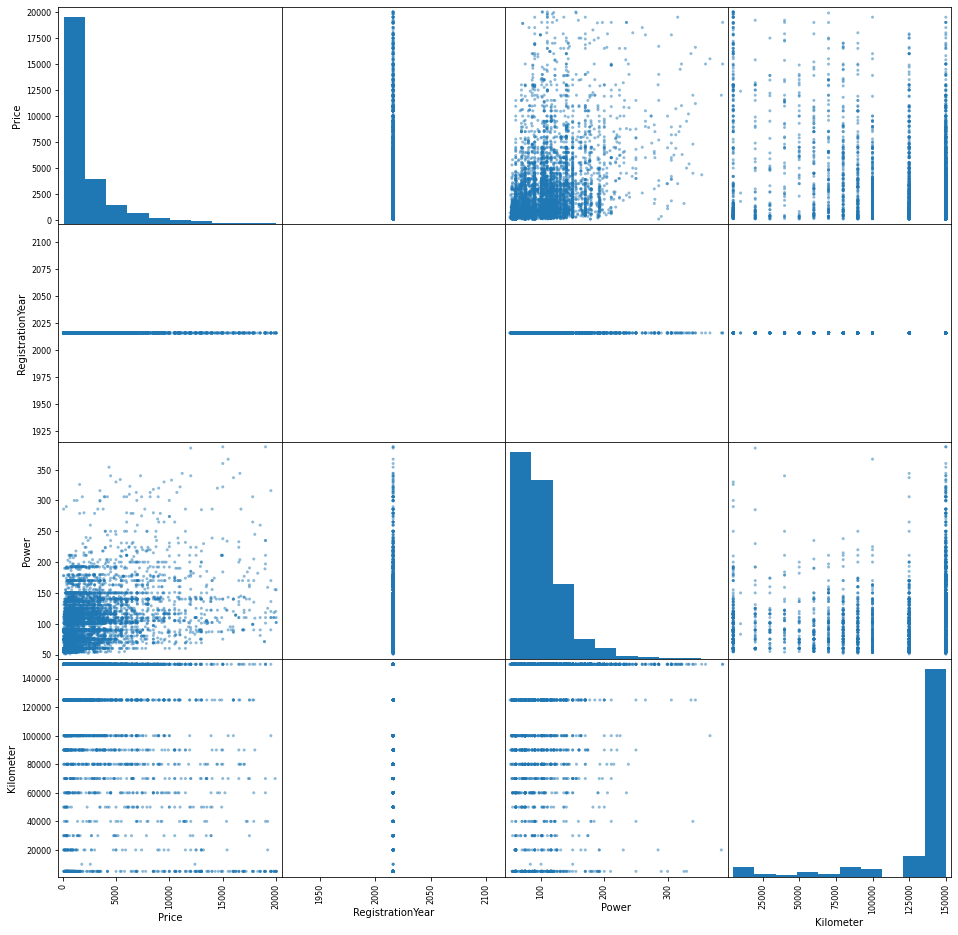

In [144]:
pd.plotting.scatter_matrix(data, figsize=(16,16))

### Вывод

* Загрзули данные 
* Удалили дубликаты
* Выделили признаки для обучения модели
* Избавились от пропусков
* Проверили корреляцию , имеем умеренную корреляцию между целевым признаком "Цена" и признаками Год регистрации, Мощность и пробег.

## Обучение моделей

In [145]:
# сделаем списки категориальных и количественных фичей
numeric = ['RegistrationYear', 'Power', 'Kilometer' ]
categorial = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [146]:
# Признаки и целевой признак без кодирования
features = data.drop(['Price'], axis=1)
target = data['Price']

In [147]:
# Некодированные тренировочная и тестовые выборки 75:25
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [148]:
features_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
225676,unknown,2016,manual,60.0,corsa,150000,petrol,opel,no
64861,unknown,2016,manual,174.0,a4,150000,petrol,audi,no
285707,unknown,2016,manual,109.0,scenic,150000,petrol,renault,no
267155,unknown,2016,manual,88.0,transporter,150000,petrol,volkswagen,no
60327,unknown,2016,manual,90.0,unknown,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...
190821,unknown,2016,manual,230.0,3er,20000,petrol,bmw,yes
176051,unknown,2016,unknown,75.0,ibiza,150000,petrol,seat,no
150311,unknown,2016,manual,60.0,punto,125000,petrol,fiat,yes
93923,unknown,2016,manual,54.0,corsa,150000,petrol,opel,no


# Ordinal Encoder


In [149]:
#Создаём объект этой структуры данных.
encoder = OrdinalEncoder()

In [150]:
# 
encoder.fit(data[categorial])
#encoder.fit(data)

OrdinalEncoder()

In [151]:
# Датасет с данными, обработанными  подрядоковым кодированием 
data_ordinal = pd.DataFrame(encoder.transform(data[categorial]), columns=[categorial], index=data.index)

In [152]:
data_ordinal = pd.merge(data[numeric], data_ordinal, how='outer', left_index=True, right_index=True)
#data_ordinal = pd.concat((data[numeric], data_ordinal), join='outer', axis=1)
data_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8380 entries, 16 to 354361
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RegistrationYear  8380 non-null   int64  
 1   Power             8380 non-null   float64
 2   Kilometer         8380 non-null   int64  
 3   (VehicleType,)    8380 non-null   float64
 4   (Gearbox,)        8380 non-null   float64
 5   (Model,)          8380 non-null   float64
 6   (FuelType,)       8380 non-null   float64
 7   (Brand,)          8380 non-null   float64
 8   (NotRepaired,)    8380 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 912.7 KB


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8380 entries, 16 to 354361
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             8380 non-null   int64  
 1   VehicleType       8380 non-null   object 
 2   RegistrationYear  8380 non-null   int64  
 3   Gearbox           8380 non-null   object 
 4   Power             8380 non-null   float64
 5   Model             8380 non-null   object 
 6   Kilometer         8380 non-null   int64  
 7   FuelType          8380 non-null   object 
 8   Brand             8380 non-null   object 
 9   NotRepaired       8380 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 978.2+ KB


In [154]:
# Коированные тренировочная и тестовые выборки 75:25
features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test = train_test_split(
    data_ordinal, data['Price'], test_size=0.25, random_state=12345)

In [155]:
print(features_ordinal_train.shape)
print(target_ordinal_train.shape)

print(features_ordinal_test.shape)
print(target_ordinal_test.shape)

(6285, 9)
(6285,)
(2095, 9)
(2095,)


In [156]:
# Масштабируем
scaler_ordinal = StandardScaler()

In [157]:
scaler_ordinal.fit(features_ordinal_train)

StandardScaler()

In [158]:
features_ordinal_train = scaler_ordinal.transform(features_ordinal_train)

In [159]:
features_ordinal_train

array([[ 0.        , -0.98200431,  0.43178208, ...,  0.40865626,
         0.09891912, -0.45882042],
       [ 0.        ,  1.86128565,  0.43178208, ...,  0.40865626,
        -1.75189912, -0.45882042],
       [ 0.        ,  0.24011155,  0.43178208, ...,  0.40865626,
         0.35130343, -0.45882042],
       ...,
       [ 0.        , -0.98200431, -0.28553405, ...,  0.40865626,
        -1.07887431,  2.17950195],
       [ 0.        , -1.13165115,  0.43178208, ...,  0.40865626,
         0.09891912, -0.45882042],
       [ 0.        , -0.43329923,  0.43178208, ...,  0.40865626,
        -0.23759329, -0.45882042]])

In [160]:
features_ordinal_test = scaler_ordinal.transform(features_ordinal_test)

In [161]:
features_ordinal_test

array([[ 0.        , -1.03188659,  0.43178208, ...,  0.40865626,
         0.35130343, -0.45882042],
       [ 0.        ,  0.04058243,  0.43178208, ...,  0.40865626,
         1.19258445,  2.17950195],
       [ 0.        , -1.13165115,  0.43178208, ...,  0.40865626,
         0.09891912, -0.45882042],
       ...,
       [ 0.        , -0.98200431,  0.43178208, ...,  0.40865626,
         0.18304722, -0.45882042],
       [ 0.        , -0.98200431, -1.28977662, ...,  0.40865626,
         0.09891912,  2.17950195],
       [ 0.        ,  2.50975529,  0.43178208, ...,  0.40865626,
         1.19258445, -0.45882042]])

# OHE - Прямое кодирование признаков

In [162]:
# Прямое кодирование признаков

data_ohe = pd.get_dummies(data, drop_first=True)
target_ohe = data_ohe['Price']
features_ohe = data_ohe.drop('Price', axis=1)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8380 entries, 16 to 354361
Columns: 250 entries, Price to NotRepaired_yes
dtypes: float64(1), int64(3), uint8(246)
memory usage: 2.5 MB


In [163]:
# Коированные тренировочная и тестовые выборки 75:25
features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

In [164]:
# масштабирование признаков
scaler_ohe = StandardScaler()

In [165]:
# Масштабируем кодированные признаки
#Было
#scaler_ohe.fit(features_ohe[numeric])
# Стало
# fit() на train выборке
scaler_ohe.fit(features_ohe_train[numeric])


StandardScaler()

In [166]:
# transform() на train и test выборках
features_ohe_train[numeric] = scaler_ohe.transform(features_ohe_train[numeric])
features_ohe_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6285 entries, 225676 to 195340
Columns: 249 entries, RegistrationYear to NotRepaired_yes
dtypes: float64(3), uint8(246)
memory usage: 1.7 MB


In [167]:
# тестовую выборку тоже
# transform() на train и test выборках
features_ohe_test[numeric] = scaler_ohe.transform(features_ohe_test[numeric])
features_ohe_test

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,NotRepaired_yes
252534,0.0,-1.031887,0.431782,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
103995,0.0,0.040582,0.431782,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
165328,0.0,-1.131651,0.431782,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
246504,0.0,3.756812,-1.289777,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
57266,0.0,0.514464,0.431782,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,0.0,-0.607887,-0.285534,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
75795,0.0,-1.106710,0.431782,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
116945,0.0,-0.982004,0.431782,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
307259,0.0,-0.982004,-1.289777,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


~~# Сделали прямое кодирование признаков
features_ohe[numeric] = scaler_ohe.transform(features_ohe[numeric])
features_ohe~~

~~# Коированные тренировочная и тестовые выборки 75:25
features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)~~

In [168]:
# Функция обучения и предсказания, на вход принимает алгоритм, признаки, целевой признак и параметры
# возвращает словарь с данными о времени обучения и rmse
def fit_predict(algo, X_train, y_train, X_test, y_test, parametrs):

    tt = []
    if algo == LinearRegression:
        model_grid = algo()

    else:
        model = algo()

        model_grid = GridSearchCV(model, parametrs, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
#        model_grid = cross_val_score(model, fit_params=parametrs, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')

    start_fit = time.time()
    model_grid_best = model_grid.fit(X_train, y_train)

    stop_fit = time.time()
    start_pred =  time.time()
    predicted = model_grid_best.predict(X_test)
    stop_pred = time.time()
    rmse = mean_squared_error(y_test, predicted) ** 0.5
    time_fit = stop_fit - start_fit
    time_predict = stop_pred - start_pred
    t = {'algo' : algo,
         'time_fit': time_fit,
         'time_predict': time_predict,
         'rmse': rmse
        }
    tt = [algo, time_fit, time_predict, rmse]
    return t

In [169]:
# Функция перебора кросс валидацией  -  не работает....
def fit_predict_cv(algo, X_train, y_train, range_param, param):

    tt = []
    if algo == LinearRegression:
        best_model_rmse = algo()
        start_fit = time.time()
        best_model_rmse.fit(X_train, y_train)
        stop_fit = time.time()
        start_pred =  time.time()
        predicted = best_model_rmse.predict(X_train)
        stop_pred = time.time()
        time_fit = stop_fit - start_fit
        time_predict = stop_pred - start_pred
        best_rmse = mean_squared_error(predicted, y_train) ** 0.5

    else:
        model_cv = algo()

#         model_grid = GridSearchCV(model, parametrs, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
        best_rmse_cv = 2500
        for depth in tqdm(range_param):
#             model_cv = model_cv()
            rmse_cv = ((cross_val_score(model_cv, features_ohe_train,target_ohe_train, cv=5, scoring='neg_mean_squared_error')).mean() * -1) ** 0.5

            print(rmse_cv)
            start_fit = time.time()
            model = model_cv.fit(X_train, y_train)
            stop_fit = time.time()
            start_pred =  time.time()
            predicted = model_cv.predict(X_train)
            stop_pred = time.time()
            if rmse_cv < best_rmse_cv:
                best_model_rmse = model
                best_depth_rmse = depth
                best_rmse = rmse_cv
                time_fit = stop_fit - start_fit
                time_predict = stop_pred - start_pred

    t = {'algo' : algo,
         'time_fit': time_fit,
         'time_predict': time_predict,
         'rmse': best_rmse
        }
    print(t)
    return t, best_model_rmse

In [170]:
# Создадим список словарей с результатами по каждой модели

all_algo = []

**Линейная регрессия**

In [171]:
%%time
# Обучим линейную регрессию на кодированной выборке
# Измерим время обучения
model = LinearRegression()
time_fit_lr = %timeit -o -n 1  -r 1 model.fit(features_ohe_train, target_ohe_train)

5.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
CPU times: user 1.24 s, sys: 4.01 s, total: 5.25 s
Wall time: 5.18 s


In [172]:
# Сохраним время обучения 
time_fit_lr

<TimeitResult : 5.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [173]:
# Сохраним время обучения 
time_fit_lr = str(time_fit_lr).split(maxsplit=2)
time_fit_lr

['5.18', 's', '± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)']

In [174]:
%%time
# Сделаем предсказания, посчитаем RMSE
lime_predict_lr = %timeit -o -n 1 -r 1 predict = model.predict(features_ohe_train)

94.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
CPU times: user 38.7 ms, sys: 143 ms, total: 182 ms
Wall time: 98.9 ms


In [175]:
lime_predict_lr = str(lime_predict_lr).split(maxsplit=2)
lime_predict_lr

['94.9', 'ms', '± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)']

In [176]:
predict = model.predict(features_ohe_train)
rmse = mean_squared_error(predict, target_ohe_train) ** 0.5

In [177]:
# Посчитаем RMSE через кросс валидацию, улучшая метрику RMSE 
model_lr = LinearRegression()
lr = ((cross_val_score(model_lr, features_ohe_train, target_ohe_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1))* -1).mean()

In [178]:
# Кросс валидация дала негативный результат...
lr

69044307849989.64

In [179]:
# Запишем результаты линейной регрессии
lr_result_train = {}
lr_result_train = {'algo' : 'Линейная регрессия',
         'time_fit': time_fit_lr[:2],
         'time_predict': lime_predict_lr[:2],
         'rmse': round(rmse)
        }
lr_result_train

{'algo': 'Линейная регрессия',
 'time_fit': ['5.18', 's'],
 'time_predict': ['94.9', 'ms'],
 'rmse': 1945}

In [180]:
all_algo.append(lr_result_train)



**DeciseionTreeRegressor**

In [181]:
# Переберем параметры для решающего дерева
# используем кросс валидацию
best_rmse_dtr = 2500
for depth in tqdm(range(1,10)):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)

    dtr = (((cross_val_score(model, features_ohe_train, target_ohe_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1))* -1).mean())

    if dtr < best_rmse_dtr:
        best_model_tree = model
        best_depth_tree = depth
        best_rmse_dtr = dtr
print(best_rmse_dtr, best_depth_tree)

100%|██████████| 9/9 [00:01<00:00,  6.78it/s]

2161.768470676679 6


In [182]:
# Обучим модель на подобранных параметрах
model = DecisionTreeRegressor(random_state=12345, max_depth=9)
time_fit_dtr = %timeit -o -n 1 -r 1 model.fit(features_ohe_train, target_ohe_train)
time_fit_dtr = str(time_fit_dtr).split(maxsplit=2)
time_fit_dtr[:2]

51.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


['51.5', 'ms']

In [183]:
# Посчитаем время предсказания на тренировочной выборке
time_predict_dtr = %timeit -o -n 1 -r 1 predict = model.predict(features_ohe_train)
time_predict_dtr = str(time_predict_dtr).split(maxsplit=2)

8.53 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [184]:
#Посчитаем RMSE Решающего дерева на тренировочной выбрке
rmse = mean_squared_error(predict, target_ohe_train)**0.5
rmse


1945.2870096872539

In [185]:
# Запишем результаты

dtr_result_train = {}
dtr_result_train = {
         'algo' : 'Решающее дерево',
         'time_fit': time_fit_dtr[:2],
         'time_predict': time_predict_dtr[:2],
         'rmse': round(best_rmse_dtr)
        }
dtr_result_train

{'algo': 'Решающее дерево',
 'time_fit': ['51.5', 'ms'],
 'time_predict': ['8.53', 'ms'],
 'rmse': 2162}

In [186]:
#Добавим результаты  по решающему дереву в итоговую талицу
#dtr['algo'] = 'Решающее дерево'
all_algo.append(dtr_result_train)

In [187]:
all_algo

[{'algo': 'Линейная регрессия',
  'time_fit': ['5.18', 's'],
  'time_predict': ['94.9', 'ms'],
  'rmse': 1945},
 {'algo': 'Решающее дерево',
  'time_fit': ['51.5', 'ms'],
  'time_predict': ['8.53', 'ms'],
  'rmse': 2162}]

**CatBoostRegressor**


In [188]:
best_rmse_cbr = 2500
for depth in tqdm(range(1,10)):
    model = CatBoostRegressor(
        random_state=12345,
        verbose=False,
        iterations=100,
        learning_rate=0.5,
        depth=depth
                             )
    cbr = (cross_val_score(model, features_ohe_train,target_ohe_train, cv=5, scoring='neg_root_mean_squared_error')).mean() * -1
    
    if cbr < best_rmse_cbr:
        best_model_cbre = model
        best_depth_cbr = depth
        best_rmse_cbr = cbr
print(best_rmse_cbr, best_depth_cbr)    

100%|██████████| 9/9 [00:48<00:00,  5.35s/it]

1840.132700419122 8


In [189]:
# Обучим модель на подобранных параметрах
model_cbr = CatBoostRegressor(
        random_state=12345,
        verbose=False,
        iterations=100,
        learning_rate=0.5,
        depth=8
                             )
time_fit_cbr = %timeit -o -n 1 -r 1 model_cbr.fit(features_ohe_train, target_ohe_train)
time_fit_cbr = str(time_fit_cbr).split(maxsplit=2)
time_fit_cbr[:2]

1.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


['1.29', 's']

In [190]:
# Посчитаем время предсказания на тренировочной выборке
time_predict_cbr = %timeit -o -n 1 -r 1 predict = model_cbr.predict(features_ohe_train)
time_predict_cbr = str(time_predict_cbr).split(maxsplit=2)


10.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [191]:

# Запишем результаты линейной регрессии
cbr_result_train = {}
cbr_result_train = {'algo' : 'CatBoostRegressor',
         'time_fit': time_fit_cbr[:2],
         'time_predict': time_predict_cbr[:2],
         'rmse': round(best_rmse_cbr)
        }
cbr_result_train

{'algo': 'CatBoostRegressor',
 'time_fit': ['1.29', 's'],
 'time_predict': ['10.9', 'ms'],
 'rmse': 1840}

In [192]:
#Добавим результаты  по решающему дереву в итоговую талицу
all_algo.append(cbr_result_train)

**LGBMRegressor**

In [193]:
best_rmse_lgbt = 2500
for depth in tqdm(range(38,39)):
    model = LGBMRegressor(
        random_state=12345,
#         verbose=False,
        n_estimators=depth,
        bagging_fraction=0.8
    #     learning_rate=0.5,
                        )
    lgbt = (cross_val_score(model, features_ordinal_train,target_ordinal_train, cv=5, scoring='neg_root_mean_squared_error')).mean() * -1
    model.fit(features_ordinal_train,target_ordinal_train)
    if lgbt < best_rmse_lgbt:
        best_model_lgbt = model
        best_depth_lgbt = depth
        best_rmse_lgbt = lgbt
        print(best_depth_lgbt, best_rmse_lgbt)
#print(best_rmse_lgbt, best_depth_lgbt)  

# model = LGBMRegressor(
#     random_state=12345,
#     verbose=False,
# #     learning_rate=0.5,
#                     )
# lgbt = (cross_val_score(model, features_ordinal_train,target_ordinal_train, cv=5, scoring='neg_root_mean_squared_error')).mean() * -1
# #lgbt = (cross_val_score(model, features_ohe_train,target_ohe_train)).mean() * -1
print(lgbt)

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


100%|██████████| 1/1 [03:12<00:00, 192.22s/it]

38 1970.4463573923574
1970.4463573923574


In [194]:
# Обучим модель на подобранных параметрах
model = LGBMRegressor(random_state=12345, bagging_fraction=0.8, n_estimators=38)
time_fit_lgbt = %timeit -o -n 1 -r 1 model.fit(features_ordinal_train,target_ordinal_train)
time_fit_lgbt = str(time_fit_lgbt).split(maxsplit=2)
time_fit_lgbt[:2]

16.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


['16.1', 's']

In [195]:
# Посчитаем время предсказания на тренировочной выборке
time_predict_lgbt = %timeit -o -n 1 -r 1 predict = model.predict(features_ordinal_train)
time_predict_lgbt = str(time_predict_lgbt).split(maxsplit=2)


85.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [196]:

# Запишем результаты линейной регрессии
lgbt_result_train = {}
lgbt_result_train = {'algo' : 'LightGBM',
         'time_fit': time_fit_lgbt[:2],
         'time_predict': time_predict_lgbt[:2],
         'rmse': round(best_rmse_lgbt)
        }
lgbt_result_train



{'algo': 'LightGBM',
 'time_fit': ['16.1', 's'],
 'time_predict': ['85.3', 'ms'],
 'rmse': 1970}

In [197]:
#Добавим результаты  по решающему дереву в итоговую талицу
all_algo.append(lgbt_result_train)

# Модель с лучшей RMSE

In [198]:
#Наш список словарей с результатами
all_algo

[{'algo': 'Линейная регрессия',
  'time_fit': ['5.18', 's'],
  'time_predict': ['94.9', 'ms'],
  'rmse': 1945},
 {'algo': 'Решающее дерево',
  'time_fit': ['51.5', 'ms'],
  'time_predict': ['8.53', 'ms'],
  'rmse': 2162},
 {'algo': 'CatBoostRegressor',
  'time_fit': ['1.29', 's'],
  'time_predict': ['10.9', 'ms'],
  'rmse': 1840},
 {'algo': 'LightGBM',
  'time_fit': ['16.1', 's'],
  'time_predict': ['85.3', 'ms'],
  'rmse': 1970}]

По метрике RMSE лучше всего CatBoostRegressor

In [199]:
#Протестируем КэтБуст на тестовой выборке

predict_cbr = model_cbr.predict(features_ohe_test)

In [200]:
rmse_cbr_test = mean_squared_error(predict_cbr, target_test) ** 0.5
rmse_cbr_test

1759.210005734491

### Вывод

* Данные были раделены на тренировочную и тестовую выборки.
* Призведено прямое кодирование признаков
* Отмасштабировали данные.
* Обучили модели, используя алгоритмы **LinearRegression, CatBoostRegressor, DecisionTreeRegressor, LGBMRegressor**. Сделали предсказания, получили метрики RMSE и время обучения и предсказания моделей не тренировочной выбрке
* Сохранили результаты в словарь

* Лучшая модель по метрике RMSE - **CatBoostRegressor**. Результат RMSE предсказаний на тестовой выборке составил 2059.56

## Анализ моделей

In [201]:

# Сделаем датафрейм и посторим графики
df_all_algo = pd.DataFrame(all_algo)
df_all_algo

,algo,time_fit,time_predict,rmse
0,Линейная регрессия,"[5.18, s]","[94.9, ms]",1945
1,Решающее дерево,"[51.5, ms]","[8.53, ms]",2162
2,CatBoostRegressor,"[1.29, s]","[10.9, ms]",1840
3,LightGBM,"[16.1, s]","[85.3, ms]",1970


In [202]:


df_all_algo.columns = ['Алгоритм', 'Время обучения', 'Время предсказания', 'rmse']
df_all_algo = df_all_algo.set_index('Алгоритм')

In [203]:
df_all_algo

,Время обучения,Время предсказания,rmse
Алгоритм,,,
Линейная регрессия,"[5.18, s]","[94.9, ms]",1945
Решающее дерево,"[51.5, ms]","[8.53, ms]",2162
CatBoostRegressor,"[1.29, s]","[10.9, ms]",1840
LightGBM,"[16.1, s]","[85.3, ms]",1970


* Быстрее всех обучилась лиенйная регрессия
* Дольше всех - CatBoost

Самый быстрый в предсказаниях CatBoost

На фоне всех алгоритмов заметно медленнее LGBMRegressor .



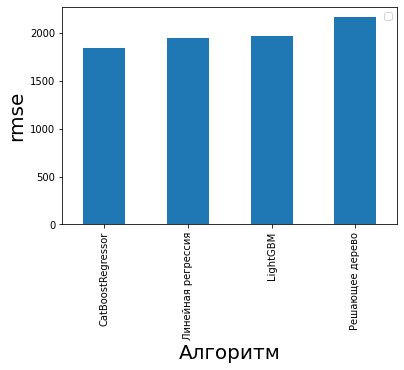

In [204]:
df_all_algo['rmse'].sort_values().plot(kind='bar')
plt.title("", fontsize=20)
plt.xlabel("Алгоритм", fontsize=20)
plt.ylabel("rmse", fontsize=20)
plt.legend('')
plt.show()

Лучшая метрика у CatBoost

### Вывод

В результате анализа полученных результатов можно сказать следующее.

Принимая во внимание, что заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Можно рекомендовать к использованию алгоритм **CatBoostRegressor**, так как он имеет лучшую метрику RMSE, быстрое предсказани, но один минус - обучается дольше всех.

Но раз в требованиях заказчика время обучения на третьем месте после качества и скорости предсказания, поэтому отдаем первое место алгоритму **CatBoostRegressor**


## Вывод



В ходе рабоы над проектом для сервиса был выбран алгоритм **CatBoostRegressor** как лучший по качеству и скорости предсказания. 

Для достижения этого результата были подгружены и обработаны данные, из которых подготовлены тренировочная и тестовая выборки, на которых уже тренировали модели по несольким алгоритмам, а именно использованы были алгоритмы:
* LinearRegression
* CatBoostRegressor
* DecisionTreeRegressor
* LGBMRegressor

Результаты обучения и предсказания алгоритмов проанализировали и выбрали соотвествующий требованиям заказчика.